# Analize Predefined and Inferred ROIs
This document is for playing and trying out ways to better infer the ROIs per person.

Matanya Wiener

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import sys
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift, estimate_bandwidth
from itertools import cycle
import ROI_actions
from ROI_actions import infer_by_center_of_mass, get_average_distance, summary_roi_coverage
# Getting my modules
sys.path.append('/home/jonathak/VisualEncoder/Analysis/Brain_maps')
from NIPS_utils import get_hemisphere_indices, get_roi_indices, get_roi_indices_per_hemisphere


# Setting up GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Appending Roman's path
sys.path.append('/home/romanb/PycharmProjects/BrainVisualReconst/')

In [3]:
# Loading the model
encoder = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
model = torch.load('/home/jonathak/VisualEncoder/Voxels_Prediction/model_ch128.pth').eval().cuda()

# Testing voxel embeddings
voxel_embeddings = model.voxel_embed # Has shape [315997, 256]

# Getting subject 1 indices

subject = 1

lh_start, lh_end = get_hemisphere_indices(subject, 'lh')
rh_start, rh_end = get_hemisphere_indices(subject, 'rh')    
sub_indices = np.arange(lh_start, rh_end)

voxel_embeddings = voxel_embeddings[sub_indices]


Using cache found in /home/matanyaw/.cache/torch/hub/facebookresearch_dinov2_main
/home/matanyaw/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/matanyaw/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/matanyaw/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [5]:
voxel_embeddings.size()

torch.Size([39548, 256])

In [4]:
# # Histogram of norms of voxel embeddings
# norms = voxel_embeddings.norm(dim=1).detach().cpu().numpy()
# print(f"Mean norm: {norms.mean():.2f}, Std norm: {norms.std():.2f}")
# plt.figure(figsize=(10, 5))
# plt.hist(norms, bins=50, color='blue', density=True, alpha=0.7)
# plt.axvline(norms.mean(), color='red', linestyle='--', label=f'Mean = {norms.mean():.2f}')
# plt.title('Histogram of Voxel Embeddings Norm')
# plt.xlabel('Norm of Voxel Embeddings')
# plt.ylabel('Density')
# plt.legend()
# plt.grid(True)
# plt.show()

In [6]:
def plot_ROI_overlap_heatmap_percentage(ROI_indices, title, ROIless_indices_amount=None):
    """
    Plots a heatmap where each cell[i, j] shows the percentage of ROI_i overlapping with ROI_j.
    Rows are ROI1, columns are ROI2.

    Parameters:
    - ROIs: list of ROI names
    - ROI_indices: dict mapping ROI name -> array of voxel indices
    - title: title for the plot
    """
    # Compute ROI sizes
    ROI_names = list(ROI_indices.keys())
    roi_sizes = {roi_name: len(ROI_indices[roi_name]) for roi_name in ROI_names}

    # Build overlap percentage matrix
    n = len(ROI_names)
    overlap_pct = np.zeros((n, n), dtype=float)
    for i, roi1 in enumerate(ROI_names):
        idx1 = ROI_indices[roi1]
        size1 = roi_sizes[roi1]
        for j, roi2 in enumerate(ROI_names):
            idx2 = ROI_indices[roi2]
            count = np.intersect1d(idx1, idx2).shape[0]
            overlap_pct[i, j] = (count / size1) * 100 if size1 > 0 else 0.0

    # Prepare labels with sizes
    xlabels = ROI_names
    ylabels = [f"{roi}\n(n={roi_sizes[roi]})" for roi in ROI_names]

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.set(style="white")
    ax = sns.heatmap(
        overlap_pct,
        annot=True, fmt='.1f', annot_kws={'size':9},
        cmap='Blues', xticklabels=xlabels, yticklabels=ylabels,
        cbar_kws={"label": "% of ROI1 overlapping ROI2", "shrink": .75},
        linewidths=0.5, linecolor='gray'
    )

     # Annotate number of ROI-less voxels if provided
    if ROIless_indices_amount is not None:
        plt.gcf().text(0.99, 0.01, f'Voxels with no assigned ROI: {ROIless_indices_amount}', ha='right', va='bottom', fontsize=10)


    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('ROI2', fontsize=12)
    plt.ylabel('ROI1', fontsize=12)
    plt.tight_layout()
    plt.show()


## Getting the predefined ROIs

ROI 'mTL-bodies' not found for subject 1
ROI 'mTL-faces' not found for subject 1
ROI 'aTL-faces' not found for subject 1
ROI 'mTL-words' not found for subject 1

Summary of ROI coverage:
Total number of voxels: 39548
Total number of voxels in ROIs: 31778
Unique voxels in ROIs: 28202
Duplicities in ROIs: 3576
Voxels not in any ROI: 11346


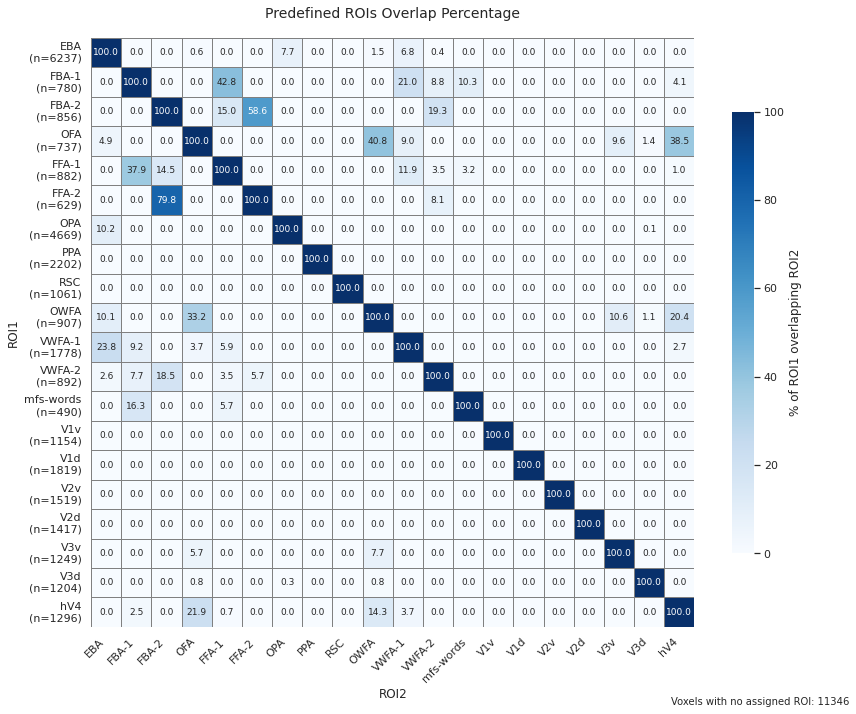

In [7]:
subject = 1

# Getting ROI indices

ROIs_bodies = ['EBA', 'FBA-1', 'FBA-2', 'mTL-bodies']
ROIs_faces = ['OFA', 'FFA-1', 'FFA-2', 'mTL-faces', 'aTL-faces']
ROIs_places = ['OPA', 'PPA', 'RSC']
ROIs_words = ['OWFA', 'VWFA-1', 'VWFA-2', 'mfs-words', 'mTL-words']
ROIs_visual = ['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']

ROI_names = ROIs_bodies + ROIs_faces + ROIs_places + ROIs_words + ROIs_visual

predefined_ROI_indices = {}

# Creating a dictionary of ROI indices (iterating over copy because we remove ROIs that don't exist)
for ROI in ROI_names.copy():
    
    roi_indices = get_roi_indices(subject, ROI)
    
    if roi_indices is None:
        ROI_names.remove(ROI)
    else:
        predefined_ROI_indices[ROI] = roi_indices
        # print(ROI, roi_indices.shape)
predefined_ROIless_indeices = summary_roi_coverage(predefined_ROI_indices, sub_indices)
plot_ROI_overlap_heatmap_percentage(predefined_ROI_indices, 'Predefined ROIs Overlap Percentage', predefined_ROIless_indeices.shape[0])

## Inferring the ROIs by the embeddings. 
We will produce a center of mass for each ROI and get the ROIs that are closest



Summary of ROI coverage:
Total number of voxels: 39548
Total number of voxels in ROIs: 31778
Unique voxels in ROIs: 13733
Duplicities in ROIs: 18045
Voxels not in any ROI: 25815


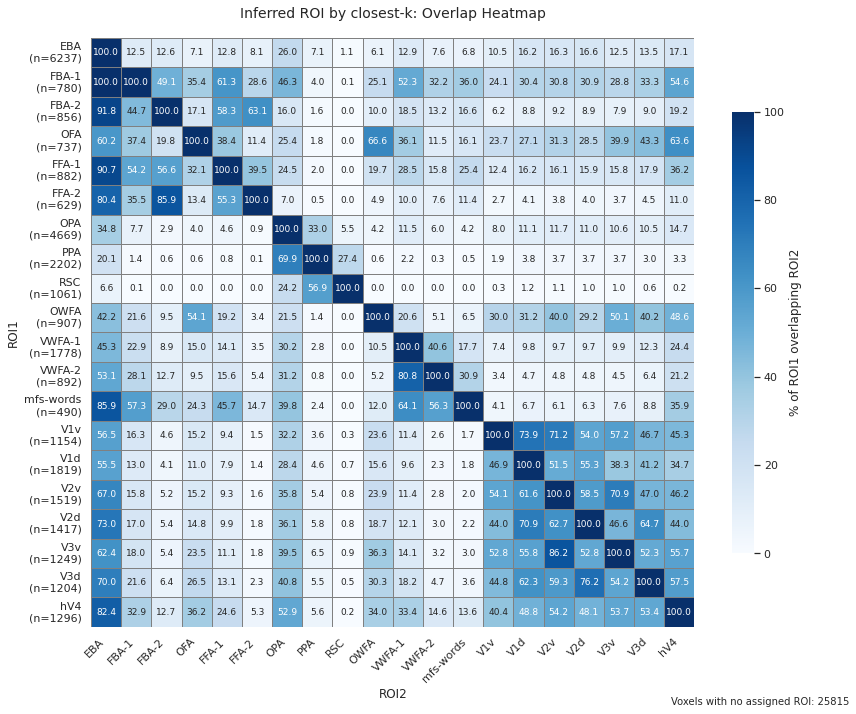

In [8]:
inferred_topk_roi_indices = {}
for ROI in ROI_names:
    size = predefined_ROI_indices[ROI].shape[0]
    if size > 0:
        inferred_topk_roi_indices[ROI] = infer_by_center_of_mass(predefined_ROI_indices[ROI], voxel_embeddings, top_k=size)

# for ROI, indices in inferred_by_size_roi_indices.items():
#     print(f"ROI: {ROI}, inferred indices: {indices.shape[0]} (predefined amount: {predefined_ROI_indices[ROI].shape[0]})")

inferred_ROIless_indices_topk = summary_roi_coverage(inferred_topk_roi_indices, sub_indices)
plot_ROI_overlap_heatmap_percentage(inferred_topk_roi_indices,
                                    title='Inferred ROI by closest-k: Overlap Heatmap',
                                    ROIless_indices_amount=inferred_ROIless_indices_topk.shape[0])

Using angle-based distance calculation.
Using angle-based distance calculation.
Using angle-based distance calculation.
Using angle-based distance calculation.
Using angle-based distance calculation.
Using angle-based distance calculation.
Using angle-based distance calculation.
Using angle-based distance calculation.
Using angle-based distance calculation.
Using angle-based distance calculation.
Using angle-based distance calculation.
Using angle-based distance calculation.
Using angle-based distance calculation.
Using angle-based distance calculation.
Using angle-based distance calculation.
Using angle-based distance calculation.
Using angle-based distance calculation.
Using angle-based distance calculation.
Using angle-based distance calculation.
Using angle-based distance calculation.

Summary of ROI coverage:
Total number of voxels: 39548
Total number of voxels in ROIs: 31778
Unique voxels in ROIs: 21192
Duplicities in ROIs: 10586
Voxels not in any ROI: 18356


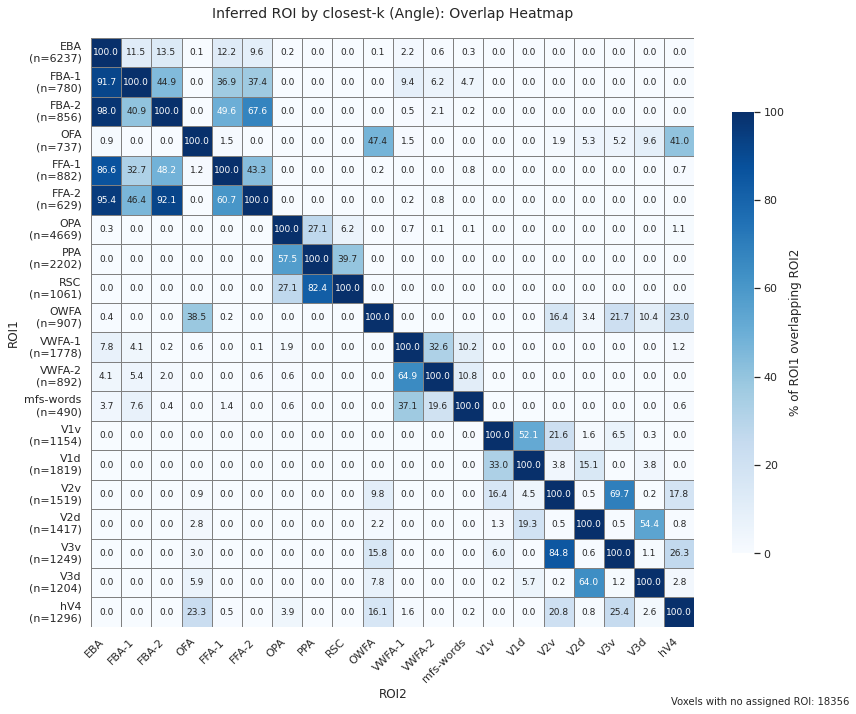

In [ ]:
inferred_angle_topk_roi_indices = {}
for ROI in ROI_names:
    size = predefined_ROI_indices[ROI].shape[0]
    if size > 0:
        inferred_angle_topk_roi_indices[ROI] = infer_by_center_of_mass(predefined_ROI_indices[ROI], voxel_embeddings, top_k=size, use_angle=True)

# for ROI, indices in inferred_by_size_roi_indices.items():
#     print(f"ROI: {ROI}, inferred indices: {indices.shape[0]} (predefined amount: {predefined_ROI_indices[ROI].shape[0]})")

inferred_angle_ROIless_indices = summary_roi_coverage(inferred_angle_topk_roi_indices, sub_indices)
plot_ROI_overlap_heatmap_percentage(inferred_angle_topk_roi_indices,
                                    title='Inferred ROI by closest-k (Angle): Overlap Heatmap',
                                    ROIless_indices_amount=inferred_angle_ROIless_indices.shape[0])



Summary of ROI coverage:
Total number of voxels: 39548
Total number of voxels in ROIs: 92909
Unique voxels in ROIs: 24544
Duplicities in ROIs: 68365
Voxels not in any ROI: 15004


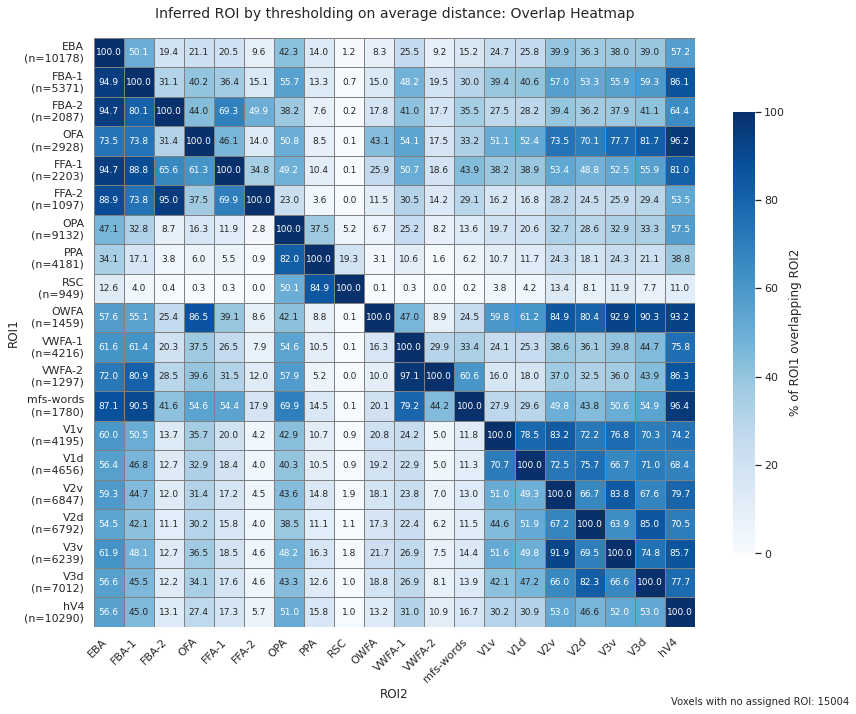

In [ ]:
avg_dist_roi_indices = {}
for ROI in ROI_names:
    avg_dist_from_center_of_mass = get_average_distance(predefined_ROI_indices[ROI], voxel_embeddings)
    avg_dist_roi_indices[ROI] = infer_by_center_of_mass(predefined_ROI_indices[ROI], voxel_embeddings, 
                                                        threshold=avg_dist_from_center_of_mass, top_k=None)


avg_dist_ROIless_indices = summary_roi_coverage(avg_dist_roi_indices, sub_indices)
plot_ROI_overlap_heatmap_percentage(avg_dist_roi_indices,
                                    title='Inferred ROI by thresholding on average distance: Overlap Heatmap',
                                    ROIless_indices_amount=avg_dist_ROIless_indices.shape[0])


In [1]:
avg_dist_angle_roi_indices = {}
for ROI in ROI_names:
    avg_dist_from_center_of_mass = get_average_distance(predefined_ROI_indices[ROI], voxel_embeddings, use_angle=True)
    avg_dist_angle_roi_indices[ROI] = infer_by_center_of_mass(predefined_ROI_indices[ROI], voxel_embeddings, 
                                                        threshold=avg_dist_from_center_of_mass, top_k=None)


avg_dist_angle_ROIless_indices = summary_roi_coverage(avg_dist_angle_roi_indices, sub_indices)
plot_ROI_overlap_heatmap_percentage(avg_dist_angle_roi_indices,
                                    title='Inferred ROI by thresholding on average distance (angle): Overlap Heatmap',
                                    ROIless_indices_amount=avg_dist_angle_ROIless_indices.shape[0])


NameError: name 'ROI_names' is not defined

In [15]:
# def infer_center_by_meanshift(predefined_ROI_indices: torch.Tensor,
#                              voxel_embeddings: torch.Tensor,
#                              quantile: float = 0.2,
#                              n_samples: int = 500) -> torch.Tensor:
#     """
#     Infer the densest center (mode) of the ROI using Mean-Shift.

#     Args:
#       predefined_ROI_indices: 1D LongTensor of voxel indices for the ROI
#       voxel_embeddings:      [num_voxels, embedding_dim] FloatTensor

#     Returns:
#       center: FloatTensor of shape [embedding_dim], the densest cluster center
#     """
#     # 1) Pull out ROI embeddings as a NumPy array
#     X = voxel_embeddings[predefined_ROI_indices].detach().cpu().numpy()

#     # 2) Estimate bandwidth (you can tweak quantile)
#     bw = estimate_bandwidth(X,
#                             quantile=quantile,
#                             n_samples=min(len(X), n_samples))
#     if bw <= 0:
#         raise ValueError(f"Bandwidth came out non-positive: {bw}")

#     # 3) Run Mean-Shift
#     ms = MeanShift(bandwidth=bw, bin_seeding=True, n_jobs=-1)
#     labels = ms.fit_predict(X)
#     centers = ms.cluster_centers_

#     # 4) Find the largest cluster
#     counts = np.bincount(labels)
#     best = counts.argmax()
#     densest_center = centers[best]

#     # 5) Convert back to torch, on the same device as voxel_embeddings
#     device = voxel_embeddings.device
#     return torch.from_numpy(densest_center).to(device).float()


In [ ]:
for ROI in ROI_names:
    indices = get_roi_indices(subject, ROI)
    voxel_embeddings_roi = voxel_embeddings[indices]
    print(f"ROI: {ROI}, indices: {indices.shape[0]}, voxel embeddings shape: {voxel_embeddings_roi.shape}")
    print(f'device: {voxel_embeddings_roi.device}')


ROI: EBA, indices: 6237, voxel embeddings shape: torch.Size([6237, 256])
device: cuda:0
ROI: FBA-1, indices: 780, voxel embeddings shape: torch.Size([780, 256])
device: cuda:0
ROI: FBA-2, indices: 856, voxel embeddings shape: torch.Size([856, 256])
device: cuda:0
ROI: OFA, indices: 737, voxel embeddings shape: torch.Size([737, 256])
device: cuda:0
ROI: FFA-1, indices: 882, voxel embeddings shape: torch.Size([882, 256])
device: cuda:0
ROI: FFA-2, indices: 629, voxel embeddings shape: torch.Size([629, 256])
device: cuda:0
ROI: OPA, indices: 4669, voxel embeddings shape: torch.Size([4669, 256])
device: cuda:0
ROI: PPA, indices: 2202, voxel embeddings shape: torch.Size([2202, 256])
device: cuda:0
ROI: RSC, indices: 1061, voxel embeddings shape: torch.Size([1061, 256])
device: cuda:0
ROI: OWFA, indices: 907, voxel embeddings shape: torch.Size([907, 256])
device: cuda:0
ROI: VWFA-1, indices: 1778, voxel embeddings shape: torch.Size([1778, 256])
device: cuda:0
ROI: VWFA-2, indices: 892, voxel

In [ ]:
meanshift_center_dict = {}

predefined_ROI_indices = {}
print("Hello, this is a test for meanshift center inference.")
# Creating a dictionary of ROI indices (iterating over copy because we remove ROIs that don't exist)
for ROI in ROI_names.copy():
    
    roi_indices = get_roi_indices(subject, ROI)
    
    if roi_indices is None:
        ROI_names.remove(ROI)
        print(f"ROI {ROI} does not exist for subject {1}. Removing from list.")

    else:
        predefined_ROI_indices[ROI] = roi_indices

    meanshift_center_dict[ROI] = ROI_actions.infer_center_by_meanshift(roi_indices, voxel_embeddings)
    # print(f"{ROI} center shape: {tuple(center_dict[ROI].shape)}")
labels, meanshift_roi_indices = ROI_actions.assign_voxels_to_rois(voxel_embeddings, meanshift_center_dict, ROI_names)




Hello, this is a test for meanshift center inference.
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...


In [ ]:
center_dict = {}
for ROI in ROI_names:
    inds = predefined_ROI_indices[ROI]   # your dict mapping ROI→Tensor of indices
    center_dict[ROI] = ROI_actions.infer_center_by_meanshift(inds, voxel_embeddings)
    # print(f"{ROI} center shape: {tuple(center_dict[ROI].shape)}")

Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...
Inferring center by meanshift...


In [ ]:
labels, meanshift_roi_indices = ROI_actions.assign_voxels_to_rois(voxel_embeddings, center_dict, ROI_names)

for roi in ROI_names:
    inds = meanshift_roi_indices[roi]
    print(f"{roi}: assigned {inds.numel()} voxels")

EBA: assigned 4255 voxels
FBA-1: assigned 1802 voxels
FBA-2: assigned 562 voxels
OFA: assigned 596 voxels
FFA-1: assigned 1010 voxels
FFA-2: assigned 552 voxels
OPA: assigned 6929 voxels
PPA: assigned 2742 voxels
RSC: assigned 1994 voxels
OWFA: assigned 1451 voxels
VWFA-1: assigned 2403 voxels
VWFA-2: assigned 1977 voxels
mfs-words: assigned 1534 voxels
V1v: assigned 1346 voxels
V1d: assigned 1702 voxels
V2v: assigned 1502 voxels
V2d: assigned 1588 voxels
V3v: assigned 1426 voxels
V3d: assigned 1780 voxels
hV4: assigned 2397 voxels



Summary of ROI coverage:
Total number of voxels: 39548
Total number of voxels in ROIs: 39548
Unique voxels in ROIs: 39548
Duplicities in ROIs: 0
Voxels not in any ROI: 0


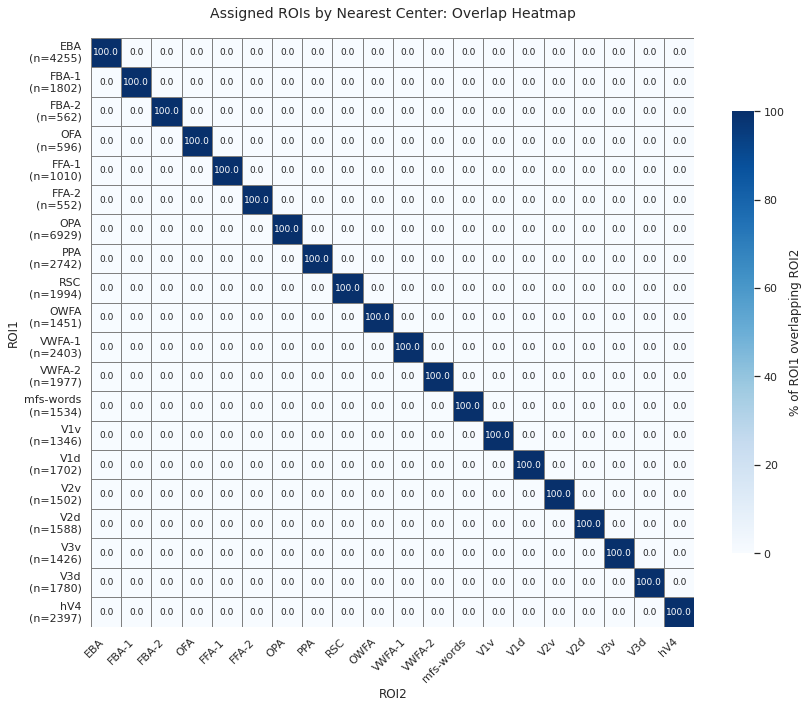

In [ ]:
# convert your new_assignment dict to numpy-only
meanshift_roi_indices_np = {
    roi: inds.cpu().numpy() if isinstance(inds, torch.Tensor) else np.array(inds)
    for roi, inds in meanshift_roi_indices.items()
}
# likewise for sub_indices if it’s a tensor
sub_indices_np = sub_indices.cpu().numpy() if isinstance(sub_indices, torch.Tensor) else sub_indices

summary_roi_coverage(meanshift_roi_indices_np, sub_indices)
plot_ROI_overlap_heatmap_percentage(meanshift_roi_indices_np,
                                    title='Assigned ROIs by Nearest Center: Overlap Heatmap')

## TSNE Plotting

In [22]:
# # # Getting tSNE embeddings
# # # ! note that I commented this out for a quick run
# tsne = TSNE(n_components=2, random_state=42, perplexity=30, metric="correlation")
# voxel_embeddings_tsne = tsne.fit_transform(voxel_embeddings.detach().squeeze().cpu().numpy())

In [23]:
def plot_all_rois_tsne(voxel_embeddings_tsne, roi_index_dict, ROIs_to_plot, title="t-SNE of All ROI Embeddings", ROIless_indices=None):
    """
    Plots t-SNE embeddings of all provided ROIs with unique colors and labels.

    Parameters:
    - voxel_embeddings_tsne: [num_voxels, 2] numpy array of t-SNE embeddings.
    - roi_index_dict: Dictionary with ROI names as keys and arrays of voxel indices as values.
    """

    # Prepare colors
    cmap = cm.get_cmap('tab20', len(ROIs_to_plot))
    color_cycle = cycle([cmap(i) for i in range(cmap.N)])

    plt.figure(figsize=(10, 8))

    for roi_name in ROIs_to_plot:
        indices = roi_index_dict.get(roi_name)
        if indices is not None and len(indices) > 0:
            color = next(color_cycle)
            plt.scatter(voxel_embeddings_tsne[indices, 0],
                        voxel_embeddings_tsne[indices, 1],
                        label=f'{roi_name} ({len(indices)})',
                        alpha=0.6,
                        s=10,
                        color=color)
    if ROIless_indices is not None and len(ROIless_indices) > 0:

        plt.scatter(voxel_embeddings_tsne[ROIless_indices, 0],
                        voxel_embeddings_tsne[ROIless_indices, 1],
                        label=f'No-ROI Voxels ({len(ROIless_indices)})',
                        alpha=0.6,
                        s=10,
                        color='black')

    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [24]:
summary_roi_coverage(meanshift_roi_indices_np, sub_indices_np)


Summary of ROI coverage:
Total number of voxels: 39548
Total number of voxels in ROIs: 39548
Unique voxels in ROIs: 39548
Duplicities in ROIs: 0
Voxels not in any ROI: 0


array([], dtype=int64)

In [25]:
# ROI categories
ROIs_to_plot = []
ROIs_to_plot.extend(ROIs_bodies)
ROIs_to_plot.extend(ROIs_faces)
ROIs_to_plot.extend(ROIs_places)
ROIs_to_plot.extend(ROIs_words)

just_all_voxels = {"voxels": sub_indices}

plot_all_rois_tsne(voxel_embeddings_tsne, predefined_ROI_indices, ROIs_to_plot, title="All Predefined ROIs t-SNE Embeddings", ROIless_indices=predefined_ROIless_indeices)
plot_all_rois_tsne(voxel_embeddings_tsne, inferred_topk_roi_indices, ROIs_to_plot, title="All Inferred ROIs t-SNE Embeddings", ROIless_indices=inferred_ROIless_indices_topk)
plot_all_rois_tsne(voxel_embeddings_tsne, meanshift_roi_indices_np, ROIs_to_plot, title="All Assigned ROIs by Nearest MeanShift Center t-SNE Embeddings")
plot_all_rois_tsne(voxel_embeddings_tsne, just_all_voxels, ["voxels"], title="Just All Voxels t-SNE Embeddings")


NameError: name 'voxel_embeddings_tsne' is not defined

Seeing the intersection between the inferred ROI voxels and the predefined ones 

In [ ]:
# # ROIs_to_plot = ['EBA', 'FFA-1', 'FFA-2', 'PPA', 'V1v']
# # ROIs_to_plot = ROIs
# ROIs_to_plot = ['FFA-1']
# for ROI in ROIs_to_plot:
#     # Get real ROI t-SNE embeddings
#     predefined_tsne = voxel_embeddings_tsne[predefined_ROI_indices[ROI]]
#     inferred_tsne = voxel_embeddings_tsne[inferred_topk_roi_indices[ROI]]

#     # _, synthetic_indices = get_embedding_based_ROI(ROI_indices[ROI], voxel_embeddings, top_k=ROI_indices[ROI].size)
#     # synthetic_tsne = voxel_embeddings_tsne[synthetic_indices.cpu().numpy()]  # assume this is the global 2D t-SNE embedding

#     # Plot
#     plt.figure(figsize=(8, 6))
#     plt.scatter(predefined_tsne[:, 0], predefined_tsne[:, 1], alpha=0.4, label='Real ROI', color='blue')
#     plt.scatter(inferred_tsne[:, 0], inferred_tsne[:, 1], alpha=0.4, label='Synthetic ROI', color='orange')

#     # Highlight intersection if needed
#     # intersection = np.intersect1d(inferred_by_size_roi_indices[ROI].cpu().numpy(), predefined_ROI_indices[ROI])
#     intersection = np.intersect1d(inferred_topk_roi_indices[ROI], predefined_ROI_indices[ROI])

#     if len(intersection) > 0:
#         plt.scatter(voxel_embeddings_tsne[intersection][:, 0],
#                     voxel_embeddings_tsne[intersection][:, 1],
#                     alpha=1.0, color='green', label='Intersection', s=10)

#     plt.title(f't-SNE: {ROI} (Real vs Synthetic)', fontsize=14)
#     plt.xlabel('t-SNE Dimension 1')
#     plt.ylabel('t-SNE Dimension 2')
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.show()


Seeing intersections between ROIs

In [ ]:
def plot_roi_intersection_tsne(roi1_indices, roi1_name, roi2_indices, roi2_name, voxel_embeddings_tsne):
    """
    Plots the t-SNE embeddings of two ROIs and their intersection.

    Parameters:
    - roi1_indices: Indices of the first ROI.
    - roi1_name: Name of the first ROI.
    - roi2_indices: Indices of the second ROI.
    - roi2_name: Name of the second ROI.
    - voxel_embeddings_tsne: t-SNE embeddings of the voxel embeddings.
    """
    plt.figure(figsize=(8, 6))

    intersection = np.intersect1d(roi1_indices, roi2_indices)
    roi1_only = np.setdiff1d(roi1_indices, intersection)
    roi2_only = np.setdiff1d(roi2_indices, intersection)

    # Plot first ROI
    plt.scatter(voxel_embeddings_tsne[roi1_only][:, 0], 
                voxel_embeddings_tsne[roi1_only][:, 1], 
                alpha=0.4, label=f'{roi1_name} ({len(roi1_indices)})', color='orange')

    # Plot second ROI
    plt.scatter(voxel_embeddings_tsne[roi2_only][:, 0], 
                voxel_embeddings_tsne[roi2_only][:, 1], 
                alpha=0.4, label=f'{roi2_name} ({len(roi2_indices)})', color='blue')

    # Highlight intersection
    if len(intersection) > 0:
        plt.scatter(voxel_embeddings_tsne[intersection][:, 0],
                    voxel_embeddings_tsne[intersection][:, 1],
                    alpha=1.0, color='green', label=f'Intersection ({len(intersection)})', s=10)

    plt.title(f't-SNE Intersection: {roi1_name} vs {roi2_name}', fontsize=14)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
ROI1 = 'OPA'
ROI2 = 'EBA'
plot_roi_intersection_tsne(predefined_ROI_indices[ROI1], f'Predefined {ROI1}', predefined_ROI_indices[ROI2], f'Predefined {ROI2}', voxel_embeddings_tsne)

# plot_roi_intersection_tsne(inferred_by_size_roi_indices[ROI1], f'Inferred {ROI1}', inferred_by_size_roi_indices[ROI2], f'Inferred {ROI2}', voxel_embeddings_tsne)

Now for each ROI we will plot it's tsne, coloring it's intersections with other ROIs

In [ ]:
for ROI in ROI_names:
    plot_roi_intersection_tsne(predefined_ROI_indices[ROI], f'Predefined {ROI}', meanshift_roi_indices_np[ROI], f'Meanshift-inferred {ROI}', voxel_embeddings_tsne)